# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some of the computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [60]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

A few examples illustrate how we can use this:

In [61]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [62]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

In the first example we have that $a = 3, b = 5$. We calculate:
$$
f = a \cdot b = 3\cdot 5 = 15 
$$
When backpropagation is called it then computes the partial derivatives with regards to the different variables and when the variabel is printed it will be returned along the partial derivative.
The partial derivatives are computed as:
$$
\begin{align}

&a: \frac{d f}{d a}=b=5.0 \newline
&b: \frac{d f}{d b}=a=3.0 \newline
&f: \frac{d f}{d f}= 1 
\end{align}
$$



For the second example it is a bit more complex. Here we have: 
$$
\begin{align}
&a = 3 \newline
&b = 5 \newline 
&c = a \cdot b = 3\cdot 5 = 15  \newline
&d = 9 \newline 
&e = a \cdot d = 3 \cdot 9 = 27 \newline 
&f = c + e = a \cdot b + a\cdot d = a \cdot (b + d) = 3 \cdot (5 + 9)= 3 \cdot 14 = 15 + 27 = 42 
\end{align}
$$


The partial derivatives can then be computed as:
$$
\begin{align}
&a: \frac{d f}{d a} =\frac{d c}{d a} + \frac{d e}{d a} = b + d = 5 + 9 = 14 \newline
&b: \frac{d f}{d b} = \frac{d c}{d b} = a = 3 \newline
&c: \frac{d f}{d c} = 1 \newline
&d: \frac{d f}{d d} = \frac{d e}{d d} = a = 3 \newline
&e:  \frac{d f}{d e} = 1 \newline 
&f: \frac{d f}{d f} = 1
\end{align}
$$

So to sum it up. Running f.backward() computes the partial derivatives for all defined variables in regards to f

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder consider the first expression. Make a schematic of the data structure which is generated when we define the expression for f. 

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

In [63]:
# import logging
!pip install graphviz
import graphviz
# configure graphviz 


#logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

#graphviz.__version__, graphviz.version()


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


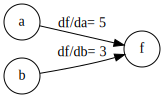

In [64]:
e1 = graphviz.Digraph('first expression', filename='fsm.gv')

e1.attr(rankdir='LR', size='8,5')

e1.attr('node', shape='circle')
# Adding nodes
e1.edge('a', 'f', label='df/da= 5') # including df/da as computed above df/da=5
e1.edge('b', 'f', label='df/db= 3')

e1

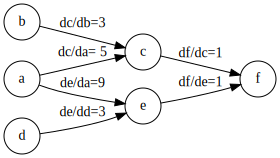

In [65]:
e2 = graphviz.Digraph('second expression', filename='fsm.gv')

e2.attr(rankdir='LR', size='8,5')

e2.attr('node', shape='circle')
e2.edge('a', 'c', label='dc/da= 5') # dc/da=5
e2.edge('b', 'c', label='dc/db=3') # dc/db = 3
e2.edge('a', 'e', label='de/da=9') # de/da=9
e2.edge('d', 'e', label='de/dd=3') # de/dd=3
e2.edge('c', 'f', label='df/dc=1') # df/dc=1
e2.edge('e', 'f', label='df/de=1') # df/de=1

e2

### Schematic of the Data Structure for the First Expression

When defining the expression $f = a \cdot b$, the underlying data structure is a computational graph, where:

- $a$ and $b$ are the **input variables** (leaf nodes).
- $f = a \cdot b$ is the **result node** that computes the product of $a$ and $b$.

This structure is typically represented as a Directed Acyclic Graph (DAG), where nodes represent variables or operations, and edges represent dependencies.

In this case, the graph looks like:

$$
a \longrightarrow f
$$
$$
b \longrightarrow f
$$

- The input variables $a$ and $b$ are connected to the output $f$.
- When the `backward()` function is called, gradients flow backward along the edges to compute the derivative of $f$ with respect to $a$ and $b$.

The key information stored in this data structure includes:
1. The **values** of the variables $a$, $b$, and $f$.
2. The **operations** performed (in this case, multiplication).
3. The **gradients** for each variable, which are used in the backward pass to calculate partial derivatives.


### Manual Execution of the Backward Function

Let's manually execute the `backward()` function for both examples to compute the gradients by hand.

### First Example: $f = a \cdot b$

Given:
- $a = 3$
- $b = 5$

We first compute the value of $f$:
$$
f = a \cdot b = 3 \cdot 5 = 15
$$

Now, let’s manually compute the partial derivatives using backpropagation:

- The derivative of $f$ with respect to $a$ is:
  $$
  \frac{\partial f}{\partial a} = b = 5
  $$

- The derivative of $f$ with respect to $b$ is:
  $$
  \frac{\partial f}{\partial b} = a = 3
  $$

- Since $f$ is the output, its derivative with respect to itself is:
  $$
  \frac{\partial f}{\partial f} = 1
  $$

Thus, the gradients are:
- $\frac{\partial f}{\partial a} = 5$
- $\frac{\partial f}{\partial b} = 3$

These gradients will be stored in the respective variables $a$ and $b$ after calling `f.backward()`.

### Second Example: $f = a \cdot b + a \cdot d$

Given:
- $a = 3$
- $b = 5$
- $d = 9$

We first compute the intermediate results:
- Compute $c$:
  $$
  c = a \cdot b = 3 \cdot 5 = 15
  $$

- Compute $e$:
  $$
  e = a \cdot d = 3 \cdot 9 = 27
  $$

- Finally, compute $f$:
  $$
  f = c + e = 15 + 27 = 42
  $$

Now, we calculate the partial derivatives using backpropagation:

- The derivative of $f$ with respect to $a$ is:
  $$
  \frac{\partial f}{\partial a} = \frac{\partial c}{\partial a} + \frac{\partial e}{\partial a} = b + d = 5 + 9 = 14
  $$

- The derivative of $f$ with respect to $b$ is:
  $$
  \frac{\partial f}{\partial b} = \frac{\partial c}{\partial b} = a = 3
  $$

- The derivative of $f$ with respect to $d$ is:
  $$
  \frac{\partial f}{\partial d} = \frac{\partial e}{\partial d} = a = 3
  $$

Thus, the gradients are:
- $\frac{\partial f}{\partial a} = 14$
- $\frac{\partial f}{\partial b} = 3$
- $\frac{\partial f}{\partial d} = 3$

These gradients will be stored in the respective variables $a$, $b$, and $d$ after calling `f.backward()`.


### Sequence of Calls to Backpropagation

The `backward()` function works by applying the chain rule to compute the gradients for each variable in the computational graph. Below is the sequence of operations that occur during backpropagation for both examples.

#### First Example: $f = a \cdot b$

In this case, the sequence of calls during backpropagation is as follows:

1. **Start at $f$**: Since $f$ is the output of the computation, its derivative with respect to itself is:
   $$
   \frac{\partial f}{\partial f} = 1
   $$

2. **Compute $\frac{\partial f}{\partial a}$**: The partial derivative of $f$ with respect to $a$ is:
   $$
   \frac{\partial f}{\partial a} = b = 5
   $$
   This value is propagated back to $a$.

3. **Compute $\frac{\partial f}{\partial b}$**: The partial derivative of $f$ with respect to $b$ is:
   $$
   \frac{\partial f}{\partial b} = a = 3
   $$
   This value is propagated back to $b$.

4. **Store the gradients**: The gradients are now stored in $a$ and $b$.

#### Second Example: $f = a \cdot b + a \cdot d$

The sequence of calls during backpropagation for this expression is more complex due to the presence of intermediate variables.

1. **Start at $f$**: Since $f$ is the output, its derivative with respect to itself is:
   $$
   \frac{\partial f}{\partial f} = 1
   $$

2. **Compute $\frac{\partial f}{\partial c}$ and $\frac{\partial f}{\partial e}$**: Since $f = c + e$, we compute the partial derivatives:
   $$
   \frac{\partial f}{\partial c} = 1 \quad \text{and} \quad \frac{\partial f}{\partial e} = 1
   $$

3. **Compute $\frac{\partial c}{\partial a}$ and $\frac{\partial c}{\partial b}$**: Since $c = a \cdot b$, we apply the chain rule:
   $$
   \frac{\partial c}{\partial a} = b = 5 \quad \text{and} \quad \frac{\partial c}{\partial b} = a = 3
   $$
   These values are propagated back to $a$ and $b$.

4. **Compute $\frac{\partial e}{\partial a}$ and $\frac{\partial e}{\partial d}$**: Since $e = a \cdot d$, we compute:
   $$
   \frac{\partial e}{\partial a} = d = 9 \quad \text{and} \quad \frac{\partial e}{\partial d} = a = 3
   $$
   These values are propagated back to $a$ and $d$.

5. **Sum the contributions to $a$**: Since $a$ appears in both $c$ and $e$, the total gradient with respect to $a$ is:
   $$
   \frac{\partial f}{\partial a} = \frac{\partial c}{\partial a} + \frac{\partial e}{\partial a} = b + d = 5 + 9 = 14
   $$

6. **Store the gradients**: The gradients are now stored in $a$, $b$, and $d$.

### Summary of Gradients

- In the first example, the gradients are $\frac{\partial f}{\partial a} = 5$ and $\frac{\partial f}{\partial b} = 3$.
- In the second example, the gradients are $\frac{\partial f}{\partial a} = 14$, $\frac{\partial f}{\partial b} = 3$, and $\frac{\partial f}{\partial d} = 3$.


## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [66]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


When `f.backward()` is run a second time, the gradients accumulate. This means the new gradients are added to the already computed gradients from the first backward pass. Since no reset occurs between passes, calling `f.backward()` two times will double the gradient.

#### Detailed Explanation:
- After the first `f.backward()`:
  - `a.grad = 14.0`
  - `b.grad = 3.0`
  - `c.grad = 2.0`
  - `d.grad = 9.0`
  - `e.grad = 2.0`
  - `f.grad = 1.0`

- After the second `f.backward()`:
  - `a.grad = 28.0` (doubled)
  - `b.grad = 6.0` (doubled)
  - `c.grad = 4.0` (doubled)
  - `d.grad = 18.0` (doubled)
  - `e.grad = 4.0` (doubled)
  - `f.grad = 2.0` (doubled)

Thus I conclude that running `f.backward()` two times will cause the gradients calculated by f.backward() to double

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [67]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


When you call `f.backprop(-1.0)`, it propagates a negative value through the computational graph, effectively subtracting the previously accumulated gradients.

### What happens:
- Initially, when you run `f.backward()` it is equivalent to running `f.backward(1)` , it accumulates gradients in all the variables according to an input of 1.
- By running `f.backprop(-1.0)`, you're applying the reverse operation, reducing the gradients by the same amount they were originally increased by.
- If you've run `f.backward()` multiple times, you must run `f.backprop(-1.0)` the same number of times to bring the gradients back to zero.


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [68]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(4.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(4.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10 , a=4.0, f_function=f_function):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    # Compute the finite difference here
    fa_da = f_function(a + da)[-1].v
    fa = f_function(a)[-1].v  

    finite_difference = (fa_da - fa) / da
    
    return finite_difference
  
print(finite_difference())

# Trying the finite difference on a different function
def g_function(a):
  a = Var(a)
  b = Var(5.0)
  c = a * b
  d = Var(9.0)
  e = a * d
  f = c + e
  f.backward()
  return a,b,c,d,e,f

for v in g_function(4.0):
  print(v)

print(finite_difference(da=1e-10, a=4.0, f_function=g_function))

Var(v=4.0000, grad=4.0000)
Var(v=4.0000, grad=4.0000)
Var(v=16.0000, grad=1.0000)
4.000000330961484
Var(v=4.0000, grad=14.0000)
Var(v=5.0000, grad=4.0000)
Var(v=20.0000, grad=1.0000)
Var(v=9.0000, grad=4.0000)
Var(v=36.0000, grad=1.0000)
Var(v=56.0000, grad=1.0000)
14.000036685501982


After comparing the finite difference derivatives with the backpropagation derivatives, it can be concluded that they agree up to the 5th decimal place when using a finite difference step size (da) of 10^-10. This indicates that the backpropagation implementation is correct and accurately computes the gradients.

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [69]:
!pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [71]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

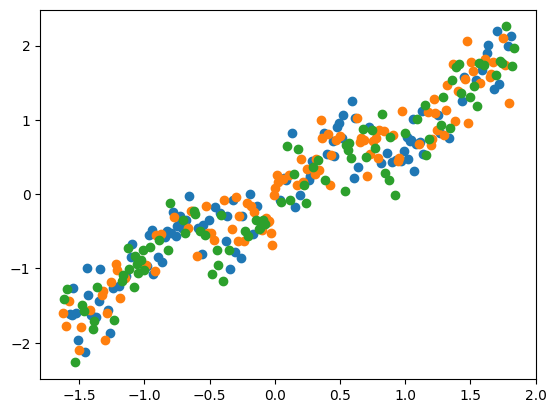

In [72]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [73]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [74]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [75]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [76]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = Var(0.0) # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += Var(0.0)  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

I add the three activation functions to the class

In [77]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)]) 
    
    # Sigmoid activation function
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)), lambda: [(self, 1/(1+exp(-self.v))*(1-1/(1+exp(-self.v))))]) # Here is the implementation of the sigmoid activation function
    
    # Tanh activation function
    def tanh(self):
        return Var((exp(self.v)-exp(-self.v))/(exp(self.v)+exp(-self.v)), lambda: [(self, 4/(exp(self.v)+exp(-self.v))**2)]) # Here is the implementation of the tanh activation function
    
    # Identity activation function
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)]) # Here is the implementation of the identity activation function

 ### The newly implemented function are the bottom three definitions 

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

To do this I need to change the DenseLayer Class. I change the node initiliazation with the bias. And I add the affine transformation in the nodes by multiplying the input by weight and sum the contributions. 
All theese changes can be found in the forward method.

In [78]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]  # <-- Initialize node with bias

            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * self.weights[i][j]  # <-- Multiply input by weight and sum
            
            node = self.act_fn(node) # <-- Apply activation function
            
            out.append(node) # <-- Append node to the output list

        return out

In [79]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0051, grad=0.0000)], [Var(v=0.0102, grad=0.0000)], [Var(v=0.0009, grad=0.0000)], [Var(v=0.0200, grad=0.0000)], [Var(v=0.0075, grad=0.0000)], [Var(v=0.0069, grad=0.0000)], [Var(v=0.0045, grad=0.0000)], [Var(v=0.0048, grad=0.0000)], [Var(v=0.0206, grad=0.0000)], [Var(v=0.0028, grad=0.0000)], [Var(v=0.0078, grad=0.0000)], [Var(v=0.0127, grad=0.0000)], [Var(v=0.0063, grad=0.0000)], [Var(v=0.0145, grad=0.0000)], [Var(v=0.0034, grad=0.0000)], [Var(v=0.0065, grad=0.0000)], [Var(v=0.0121, grad=0.0000)], [Var(v=0.0057, grad=0.0000)], [Var(v=0.0006, grad=0.0000)], [Var(v=0.0020, grad=0.0000)], [Var(v=0.0095, grad=0.0000)], [Var(v=0.0042, grad=0.0000)], [Var(v=0.0088, grad=0.0000)], [Var(v=0.0089, grad=0.0000)], [Var(v=0.0056, grad=0.0000)], [Var(v=0.0150, grad=0.0000)], [Var(v=0.0114, grad=0.0000)], [Var(v=0.0126, grad=0.0000)], [Var(v=0.0013, grad=0.0000)], [Var(v=0.0079, grad=0.0000)], [Var(v=0.0188, grad=0.0000)], [Var(v=0.0019, grad=0.0000)], [Var(v=0.0164, grad=0.0000)], [Var(v=0.

I conclude that my implemented changes works for the NN

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

I modify the Denselayer class again. I add the print_parameters method to the class as to enable it to printout the biases and weights of the network. 

In [80]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias
  
    # Method to print parameters of the layer
    def print_parameters(self, layer_num: int):
        print(f"Layer {layer_num} - Weights:")
        for i, row in enumerate(self.weights):
            print(f"  Node {i} weights: {[w.v for w in row]}")  # <-- Access the `v` attribute
        print(f"Layer {layer_num} - Biases:")
        print(f"  Biases: {[b.v for b in self.bias]}")  # <-- Access the `v` attribute

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]  # <-- Initialize node with bias

            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * self.weights[i][j]  # <-- Multiply input by weight and sum
            
            node = self.act_fn(node) # <-- Apply activation function
            
            out.append(node) # <-- Append node to the output list

        return out

Then I make a helping function to print all network parameters. This functioun enumerates through the network calling the print_parameters method

In [81]:
def print_network_parameters(network):
    for idx, layer in enumerate(network):
        layer.print_parameters(idx + 1)


I call the function for a new network structure

In [82]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

print_network_parameters(NN)

Layer 1 - Weights:
  Node 0 weights: [0.07565105280753476, 0.1221598154427432, -0.02992603368424436, 0.058653238470548985, -0.04511919006761711]
Layer 1 - Biases:
  Biases: [0.0, 0.0, 0.0, 0.0, 0.0]
Layer 2 - Weights:
  Node 0 weights: [-0.1364282022952396]
  Node 1 weights: [0.06497243305843113]
  Node 2 weights: [-0.03786665173795694]
  Node 3 weights: [-0.12651563719567382]
  Node 4 weights: [-0.17777752057163776]
Layer 2 - Biases:
  Biases: [0.0]


I conclude that it works as intended

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

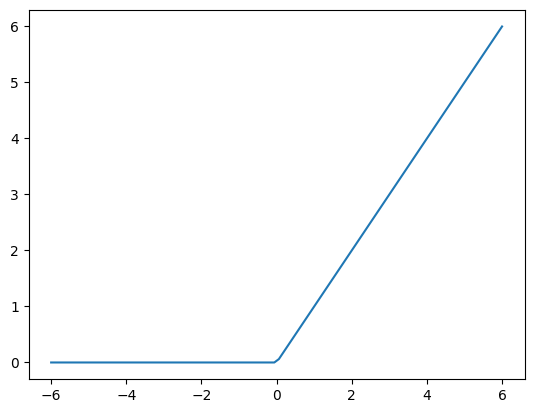

In [83]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

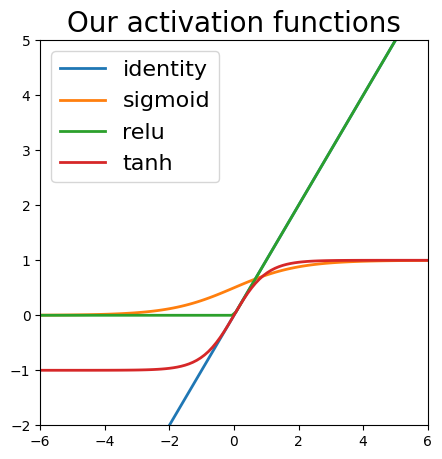

In [84]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

### I conclude that my implementation of the activation functions works as intended

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

FIrst I implement the glorot tanh initialization method and then the He initialization. 

In [85]:
import numpy as np
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int, alpha=1):
  std = np.sqrt(2 * alpha) / (n_in + n_out)  # α = 1 for tanh in glorot initialization : w_ij ~ N(0, 2 *alpha/(n_in + n_out))
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int,alpha=2):
  std = np.sqrt( alpha / n_in)  # α = 2 for ReLU in He initialization : w_ij ~ N(0, alpha/n_in)
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

Making a universal intializer

In [86]:
# Making a universal initializer that uses DenseLayer_Glorot_tanh and DenseLayer_He_relu choosing between them based on act = 'Glorot' or act = 'He'
def universal_initializer(n_in: int, n_out: int,alpha, act: str):
  if act == 'Glorot':
    return DenseLayer_Glorot_tanh(n_in, n_out, alpha)
  elif act == 'He':
    return DenseLayer_He_relu(n_in, n_out,alpha)
  else:
    raise ValueError("act must be 'Glorot' or 'He'")

### To test numerically that the Glorot initialization maintains the desired properties of variance across layers and stable gradient propagation, I would follow these steps:

1. **Monitor Activation and Gradient Distributions**: 
   - Plot histograms of activation values and gradients at initialization for both standard and Glorot initialization methods, as shown in Figures 6, 7, and 8 of the Glorot paper. Check whether the gradients vanish or explode as they propagate through the layers.

2. **Track Error Curves**: 
   - Plot the test error over time during training for different initialization methods, as in Figure 11 in  the paper. Successful initialization should show faster convergence and lower final error.

These tests would numerically confirm that the initialization maintains the variance of activations and gradients, which is key for stable deep network training.


## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

### Forward Pass Unit Test

The forward pass unit test constructs a simple neural network with:

- **3 input nodes**
- **Identity activation function**
- **2 output nodes**

The weights are all initialized to 1, and the biases are initialized to 0. Therefore, the expected output for both output nodes can be calculated as follows:

$$
\text{output}_0 = 1 \times 1 + 1 \times 1 + 1 \times 1 + 0 = 3
$$

$$
\text{output}_1 = 1 \times 1 + 1 \times 1 + 1 \times 1 + 0 = 3
$$

Hence, the expected output for both nodes is `[3, 3]`.


In [87]:
def forward_pass_unit_test():
    # Create a DenseLayer with ConstantInitializer (all weights = 1, biases = 0)
    n_in, n_out = 3, 2  # Example: 3 input nodes, 2 output nodes
    layer = DenseLayer(n_in, n_out, lambda x: x.identity(), initializer=ConstantInitializer(weight=1.0, bias=0.0))

    # Input: Vector of 1's
    input_values = [Var(1.0), Var(1.0), Var(1.0)]  # Input has 3 values all set to 1

    # Perform the forward pass
    output = layer.forward(input_values)

    # Convert the Var objects to their actual values for comparison
    output_values = [o.v for o in output]

    # Expected output:
    # For each output node:
    # output_j = sum(input_i * weight_ij) + bias_j
    # Since all inputs and weights are 1, and bias is 0:
    # output_0 = 1*1 + 1*1 + 1*1 + 0 = 3
    # output_1 = 1*1 + 1*1 + 1*1 + 0 = 3
    expected_output = [3.0, 3.0]

    # Check if the output matches the expected output
    for out, expected in zip(output_values, expected_output):
        print(out, expected)
        assert out == expected, f"Expected {expected}, but got {out}"

    print("Forward pass unit test passed!")

# Run the unit test
forward_pass_unit_test()

3.0 3.0
3.0 3.0
Forward pass unit test passed!


### I conclude my implementation of the forward pass works as intended

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [88]:
def squared_loss(t, y):
  
  # add check that sizes agree 
  assert len(t) == len(y), "t and y must have the same length"
    
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

### First I add the exp and log method to var class

In [89]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)]) 
    
    # Sigmoid activation function
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)), lambda: [(self, 1/(1+exp(-self.v))*(1-1/(1+exp(-self.v))))]) # Here is the implementation of the sigmoid activation function
    
    # Tanh activation function
    def tanh(self):
        return Var((exp(self.v)-exp(-self.v))/(exp(self.v)+exp(-self.v)), lambda: [(self, 4/(exp(self.v)+exp(-self.v))**2)]) # Here is the implementation of the tanh activation function
    
    # Identity activation function
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)]) # Here is the implementation of the identity activation function
    # exp
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    # log
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

### Then I define the LogSumExp function

In [90]:
# LogSumExp(h) = log(sum_i' exp(h_i'))
def log_sum_exp(h):
    log_sum = Var(0.0)
    for i in range(len(h)):
        log_sum += h[i].exp()
    return log_sum.log()


### Finally I add the Cross entropy loss function 

In [91]:
def cross_entropy_loss(t_batch, h_batch):
    """
    Cross-entropy loss for batches of data using the logits formulation.
    
    Args:
    t_batch: batch of target vectors (one-hot encoded)
    h_batch: batch of logits vectors (pre-softmax)
    
    Returns:
    Cross-entropy loss value for the batch
    """
    # Check that batch sizes agree
    assert len(t_batch) == len(h_batch), "t_batch and h_batch must have the same batch size"
    
    # Initialize total loss for the batch
    total_loss = Var(0.0)
    
    # Iterate over each element in the batch
    for t, h in zip(t_batch, h_batch):
        # Add check that sizes agree within each sample
        assert len(t) == len(h), "Each t and h must have the same length"
        
        
        # Compute the loss for a single sample: - sum_i t_i h_i + LogSumExp(h)
        Loss = Var(0.0)
        for i in range(len(t)):
            Loss += -t[i] * h[i]  # t_i * h_i term

        Loss += log_sum_exp(h)  # LogSumExp term
        
        # Accumulate the loss for the batch
        total_loss += Loss
    
    # Optionally, return the average loss across the batch
    return total_loss / Var(float(len(t_batch)))


I test the cross entropy function  

In [92]:
# Example usage with a batch of Var objects for t_batch and h_batch
t_batch = [[Var(1.0), Var(0.0), Var(0.0)], [Var(0.0), Var(1.0), Var(0.0)]]  # Example one-hot target batch
h_batch = [[Var(2.0), Var(1.0), Var(0.1)], [Var(0.5), Var(2.0), Var(0.5)]]  # Example logits batch

# Compute expected loss
expected_loss = Var(0.0)
for t, h in zip(t_batch, h_batch):
    for i in range(len(t)):
        expected_loss += -t[i] * h[i]
    expected_loss += log_sum_exp(h)
    
expected_loss /= Var(float(len(t_batch)))


# Compute the cross-entropy loss
loss = cross_entropy_loss(t_batch, h_batch)

# compare by printing
print(loss.v, expected_loss.v)


0.3930055758395743 0.3930055758395743


### I conclude my implementation of the Cross Entropy loss function works 

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [93]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()


and the gradients will be calculated:

In [94]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=0.1123, grad=1.3254), Var(v=-0.0443, grad=-2.4394), Var(v=0.0822, grad=20.5421), Var(v=0.0345, grad=-11.7762), Var(v=-0.1352, grad=3.0101)]] Biases: [Var(v=0.0000, grad=1.1382), Var(v=0.0000, grad=2.2171), Var(v=0.0000, grad=17.6408), Var(v=0.0000, grad=-10.1130), Var(v=0.0000, grad=-2.7359)]
Layer 1 
 Weights: [[Var(v=-0.0129, grad=-11.5755)], [Var(v=0.0255, grad=4.2423)], [Var(v=-0.1992, grad=-8.4723)], [Var(v=0.1142, grad=-3.5589)], [Var(v=-0.0315, grad=12.9394)]] Biases: [Var(v=0.0000, grad=-1.5737)]


[None, None]

I Try with cross Entropy loss 

In [95]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = cross_entropy_loss(y_train,output)
Loss.backward()


In [96]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.0364, grad=0.0002), Var(v=-0.0965, grad=-0.1331), Var(v=0.0516, grad=-0.0018), Var(v=-0.0653, grad=-0.0709), Var(v=-0.1073, grad=0.0760)]] Biases: [Var(v=0.0000, grad=-0.0003), Var(v=0.0000, grad=0.1363), Var(v=0.0000, grad=0.0034), Var(v=0.0000, grad=0.0727), Var(v=0.0000, grad=-0.0779)]
Layer 1 
 Weights: [[Var(v=-0.0003, grad=0.0327)], [Var(v=0.1481, grad=0.0867)], [Var(v=0.0425, grad=-0.0022)], [Var(v=0.0790, grad=0.0587)], [Var(v=-0.0846, grad=0.0964)]] Biases: [Var(v=0.0000, grad=1.0000)]


[None, None]

Compare squared and Cross Entropy Loss

In [97]:
# Compare squared loss with cross entropy loss
# squared loss
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

sq_loss = squared_loss(y_train,output)

# cross entropy loss
ce_loss = cross_entropy_loss(y_train,output)

print(sq_loss.v, ce_loss.v)

106.15083425188958 -0.0015412770228616774


### I conclude that for both Squared Error And Cross Entropy loss my neural networks forward pass works

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [98]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [99]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0261, grad=-4.7674), Var(v=-0.0629, grad=-6.2346), Var(v=0.0665, grad=-2.0322), Var(v=0.0882, grad=-8.0236), Var(v=0.1455, grad=11.8050), Var(v=-0.1538, grad=-1.0669), Var(v=0.1888, grad=2.9012), Var(v=0.1032, grad=2.3578), Var(v=0.0631, grad=-6.6163), Var(v=-0.1022, grad=1.3786), Var(v=0.0051, grad=1.0839), Var(v=-0.0715, grad=2.0440), Var(v=-0.0462, grad=-3.0948), Var(v=-0.0158, grad=1.1669), Var(v=0.1042, grad=3.7795)]] Biases: [Var(v=0.0000, grad=-4.0940), Var(v=0.0000, grad=5.6673), Var(v=0.0000, grad=-1.7451), Var(v=0.0000, grad=-6.8902), Var(v=0.0000, grad=10.1375), Var(v=0.0000, grad=0.9698), Var(v=0.0000, grad=2.4914), Var(v=0.0000, grad=2.0247), Var(v=0.0000, grad=-5.6817), Var(v=0.0000, grad=-1.2531), Var(v=0.0000, grad=0.9308), Var(v=0.0000, grad=-1.8581), Var(v=0.0000, grad=2.8133), Var(v=0.0000, grad=-1.0607), Var(v=0.0000, grad=3.2456)]
Layer 1 
 Weights: [[Var(v=0.2472, grad=0.3820), Var(v=0.1070, grad=0.0000), Var(v=-

[None, None, None]

In [100]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [101]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [102]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 108.180 	 Validation loss: 106.147
  10 ( 5.00%) Train loss: 51.970 	 Validation loss: 39.528
  20 (10.00%) Train loss: 18.854 	 Validation loss: 14.666
  30 (15.00%) Train loss: 15.934 	 Validation loss: 11.649
  40 (20.00%) Train loss: 12.850 	 Validation loss: 9.909
  50 (25.00%) Train loss: 12.248 	 Validation loss: 9.441
  60 (30.00%) Train loss: 12.149 	 Validation loss: 9.314
  70 (35.00%) Train loss: 12.110 	 Validation loss: 9.256
  80 (40.00%) Train loss: 12.083 	 Validation loss: 9.173
  90 (45.00%) Train loss: 12.065 	 Validation loss: 9.136
 100 (50.00%) Train loss: 12.047 	 Validation loss: 9.139
 110 (55.00%) Train loss: 12.035 	 Validation loss: 9.083
 120 (60.00%) Train loss: 12.021 	 Validation loss: 9.084
 130 (65.00%) Train loss: 12.010 	 Validation loss: 9.067
 140 (70.00%) Train loss: 12.001 	 Validation loss: 9.018
 150 (75.00%) Train loss: 11.992 	 Validation loss: 9.008
 160 (80.00%) Train loss: 11.985 	 Validation loss: 9.000
 170 (85

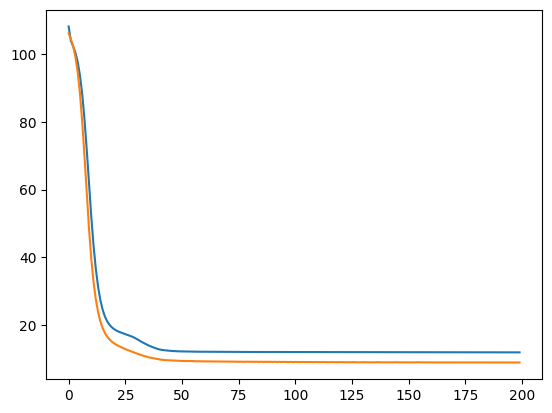

In [103]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [104]:
output_test = forward(x_test, NN)

Test loss:  10.002


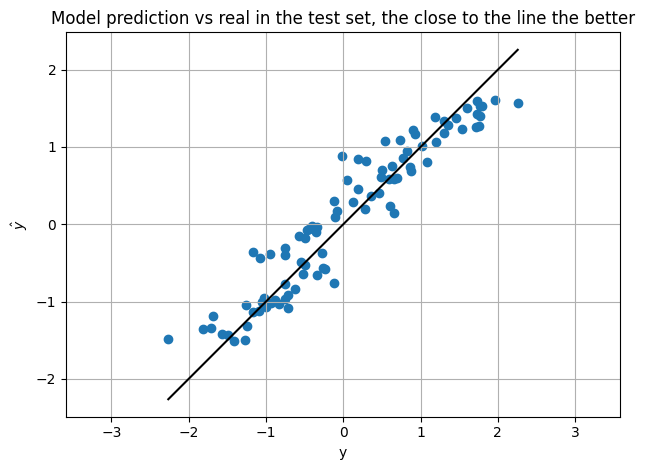

In [105]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

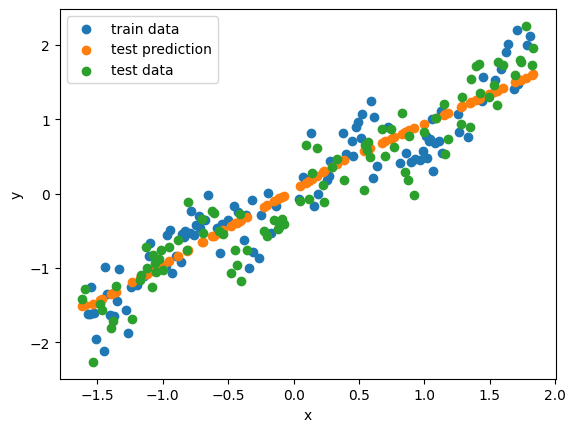

In [106]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.



### Good fit
Here I try to produce a good fit to the network by implementing a 3 layer deep neural network with 16 neurons in each layer, a intermediate amount of epochs and an intermediate learning rate. 

   0 ( 0.00%) Train loss: 106.093 	 Validation loss: 107.400
  10 ( 2.00%) Train loss: 92.526 	 Validation loss: 90.774
  20 ( 4.00%) Train loss: 14.693 	 Validation loss: 11.103
  30 ( 6.00%) Train loss: 13.965 	 Validation loss: 10.757
  40 ( 8.00%) Train loss: 22.569 	 Validation loss: 20.007
  50 (10.00%) Train loss: 14.160 	 Validation loss: 10.974
  60 (12.00%) Train loss: 15.868 	 Validation loss: 12.911
  70 (14.00%) Train loss: 15.213 	 Validation loss: 11.976
  80 (16.00%) Train loss: 13.866 	 Validation loss: 10.714
  90 (18.00%) Train loss: 13.865 	 Validation loss: 10.740
 100 (20.00%) Train loss: 13.650 	 Validation loss: 10.535
 110 (22.00%) Train loss: 13.047 	 Validation loss: 9.916
 120 (24.00%) Train loss: 12.795 	 Validation loss: 9.739
 130 (26.00%) Train loss: 13.120 	 Validation loss: 10.091
 140 (28.00%) Train loss: 13.177 	 Validation loss: 10.126
 150 (30.00%) Train loss: 12.626 	 Validation loss: 9.587
 160 (32.00%) Train loss: 12.597 	 Validation loss: 9.603

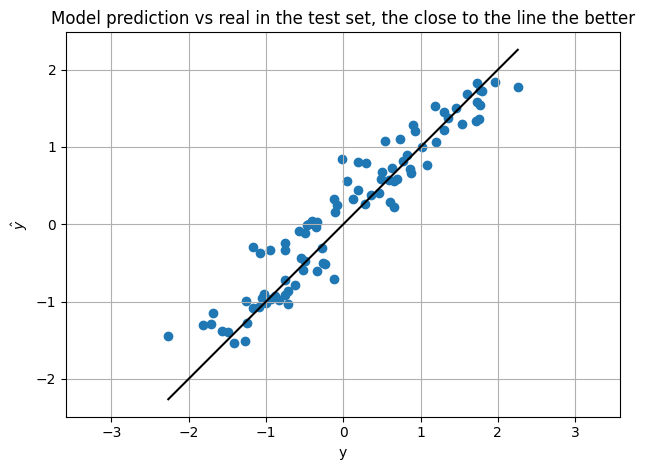

In [124]:


#For overfitting, we will use a very complex model with a lot of layers and nodes
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 16, lambda x: x.relu()),
    DenseLayer(16, 16, lambda x: x.relu()),
    DenseLayer(16, 1, lambda x: x.identity())
]


# Initialize training hyperparameters
EPOCHS = 500
LEARN_R = 2e-3 

#training 

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# testing

output_test = forward(x_test, NN)

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

For the good network the validation loss is around 8.76 and the test loss is 9.84. This is not a great difference in the two errors and in this instance the validation error is a good substitute for a test loss.  

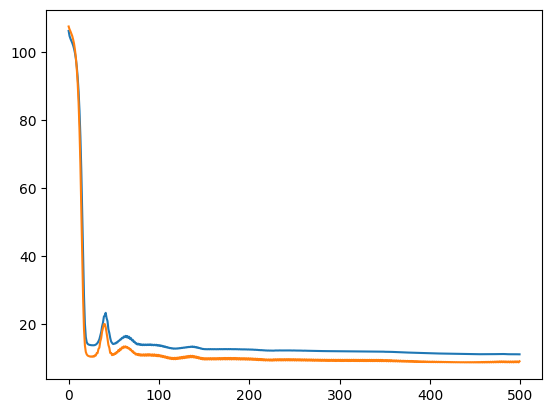

In [125]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

### Underfitting

## Underfitting
To demonstrate underfitting, we initialize a shallow network where:
- The number of nodes is too low.
- The network architecture is too simple (too few layers).
- The number of training epochs is too small.

This results in a model that is too simple to capture the underlying patterns in the data, leading to poor performance on both the training and validation sets.


   0 ( 0.00%) Train loss: 108.218 	 Validation loss: 109.361
  10 (20.00%) Train loss: 92.081 	 Validation loss: 85.795
  20 (40.00%) Train loss: 26.735 	 Validation loss: 21.380
  30 (60.00%) Train loss: 20.222 	 Validation loss: 15.841
  40 (80.00%) Train loss: 16.035 	 Validation loss: 12.558
Test loss:  10.738


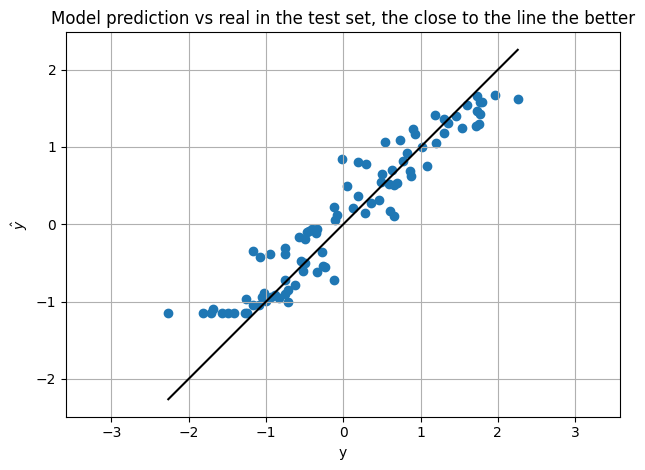

In [137]:
# Underfitting
# Initialize an underfittet model by a shallow network where the number of nodes is too low, the network too shallow aand the epochs too low

# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 2, lambda x: x.relu()),
    DenseLayer(2, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 50
LEARN_R = 2e-3

#training 

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# testing

output_test = forward(x_test, NN)

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

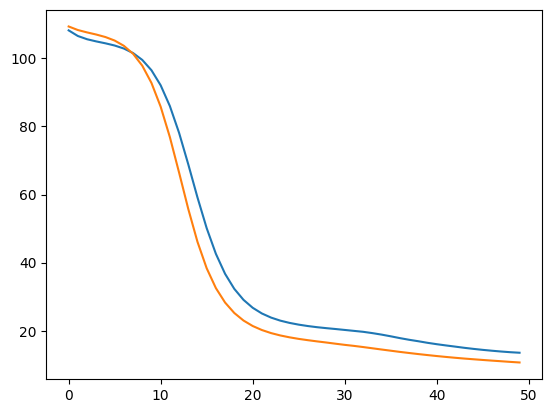

In [138]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

Here the underfitted network performs fairly well despise only having two hidden units. It had a validation loss around 12 and a test loss around 10.7. However it is underfitted in the sense that it have been trained for to few epoch meaning that it has not fully captured the information of the training set. Furthermore it is underfitted as I would theorize 2 hidden units is not enough to capture all the variety of the set. 

## Overfitting
For overfitting, we will use a very complex model with:
- 4 layers, each with 8 nodes.
- A large number of training epochs.

This setup makes the model too complex for the data, allowing it to overfit to the training set, capturing noise and irrelevant patterns, leading to poor generalization on the validation set.


   0 ( 0.00%) Train loss: 104.974 	 Validation loss: 107.647
  10 ( 2.00%) Train loss: 104.851 	 Validation loss: 107.586
  20 ( 4.00%) Train loss: 104.673 	 Validation loss: 107.369
  30 ( 6.00%) Train loss: 104.302 	 Validation loss: 106.859
  40 ( 8.00%) Train loss: 103.233 	 Validation loss: 105.621
  50 (10.00%) Train loss: 98.022 	 Validation loss: 98.982
  60 (12.00%) Train loss: 45.270 	 Validation loss: 31.073
  70 (14.00%) Train loss: 72.648 	 Validation loss: 47.727
  80 (16.00%) Train loss: 18.705 	 Validation loss: 17.081
  90 (18.00%) Train loss: 27.325 	 Validation loss: 20.135
 100 (20.00%) Train loss: 24.654 	 Validation loss: 19.365
 110 (22.00%) Train loss: 24.972 	 Validation loss: 18.802
 120 (24.00%) Train loss: 23.302 	 Validation loss: 18.115
 130 (26.00%) Train loss: 21.734 	 Validation loss: 17.100
 140 (28.00%) Train loss: 20.852 	 Validation loss: 16.383
 150 (30.00%) Train loss: 20.244 	 Validation loss: 15.733
 160 (32.00%) Train loss: 19.233 	 Validation 

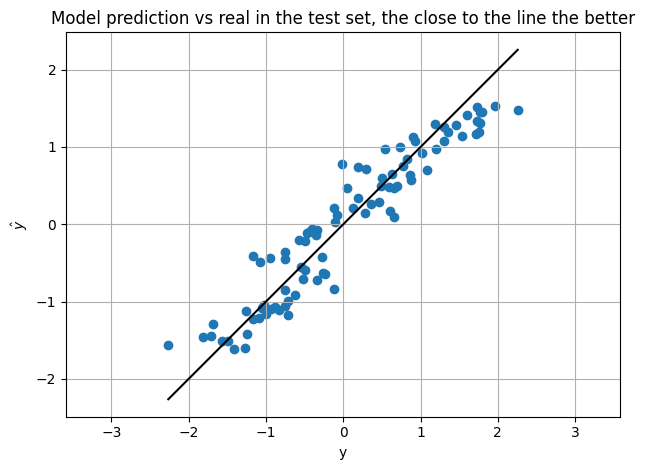

In [141]:

#Trying to do a good fit
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]


# Initialize training hyperparameters
EPOCHS = 500
LEARN_R = 2e-3 

#training 

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# testing

output_test = forward(x_test, NN)

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

For the overfitted network the validation loss of 10 is slightly better than the test lost at 9.776. This discrepancy might come from the fact that it has learned the training datas variability in the added noise. 

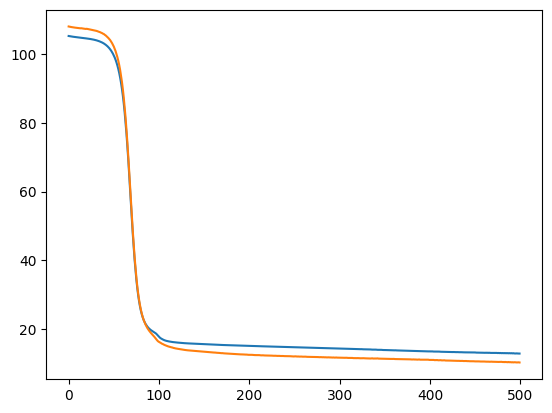

In [112]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

### Discussion on validation loss vs test loss

**For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.**


In this problem, I noticed different behaviors when comparing validation and test losses across various models:

- **Underfitted Network**: For the underfitted network, the validation loss was **12**, while the test loss was **10.7**. The relatively small difference suggests that the model has not fully captured the complexity of the training data. Although the losses are somewhat close, the model underfits the data, as evidenced by the simple architecture and low number of training epochs. This means the model hasn't fully learned the underlying patterns, but it shows some potential for improvement with more training or complexity.

- **Overfitted Network**: In the case of the overfitted network, the validation loss was **9.776**, while the test loss came in at **10.36**. The small gap between the two values indicates that the model is overfitting slightly, likely capturing noise from the training set. Despite this, the model still generalizes reasonably well, as the difference between the validation and test losses remains small.

- **Well-Fitted Network**: For the well-fitted network, the test loss was **9.84**, and the validation loss was **8.76**. The minimal difference between the two values suggests that the model is generalizing well and has captured the patterns in the data effectively. In this case, the validation loss is a reliable proxy for the test loss, indicating a balanced model that is neither underfitting nor overfitting.


### Why It’s Important to Keep Validation and Test Sets Separate:

While the validation and test losses were close for both the well-fitted and overfitted networks, suggesting that the validation loss was a good approximation of the test loss, I think it's still important to keep the two sets separate in certain situations:

1. **Model Selection and Hyperparameter Tuning**: During the training process, I use validation data to tune hyperparameters and choose the best model architecture. If I were to use the test set for this, there’s a risk of overfitting to the test data, which could give an overly optimistic sense of the model’s performance. So, I believe it's a good practice to reserve the test set for final evaluation.

2. **Avoiding Overfitting to the Validation Set**: If the validation set is heavily used during tuning, the model might start overfitting to it. This reduces its effectiveness as a measure of generalization. By keeping the test set separate, I can ensure that the final evaluation remains unbiased and truly reflects the model’s ability to handle unseen data.

3. **High-Stakes Applications**: In situations like medical diagnostics or financial forecasting, where accuracy is critical, I think it's especially important to evaluate the model on data that hasn’t been involved in any part of the training or validation process. This helps prevent overestimating the model’s real-world performance and ensures it can generalize well in new, unseen scenarios.

### Conclusion:
In this problem, I found that for both the well-fitted and overfitted networks, the differences between validation and test losses were small, which suggests that the validation loss can be a reliable indicator of generalization performance. However, with the underfitted network, the large gap between the two losses shows that the model still has a lot of learning to do. Overall, I think it’s important to keep validation and test sets separate, especially in critical applications, to ensure that model evaluations are as accurate and unbiased as possible. 


# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [113]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [114]:
# just add some code